# Evaluation Curve For ML

Reference:
* [sklearn PR curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
* [机器学习之类别不平衡问题 (2) —— ROC和PR曲线](https://zhuanlan.zhihu.com/p/34655990)
* Implementation Reference - https://github.com/massquantity/Class-Imbalance

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data

In [2]:
X, y = make_classification(n_samples=2000, n_features=10, n_informative=4, n_redundant=1, n_classes=2,
                          n_clusters_per_class=1, weights=[0.9,0.1], flip_y=0.1, random_state=2018)
print("positive/negative = %s/%s" % (len(y[y==1]), len(y[y==0])))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
X_pca.columns=["pca_a", "pca_b"]
X_pca["y"] = y

positive/negative = 289/1711


Using **PCA** to display 0/1 data in 2D view

Text(11.835, 0.5, 'axis_2')

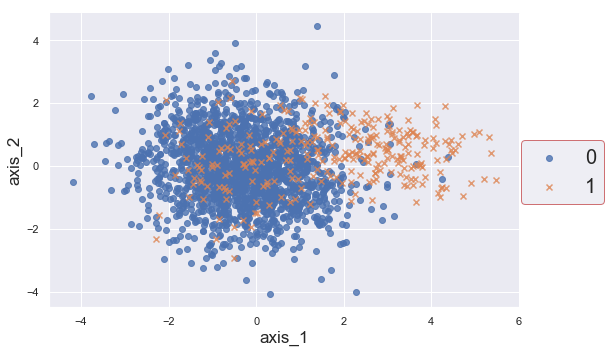

In [3]:
sns.set()
sns.lmplot("pca_a", "pca_b", data=X_pca, hue="y", fit_reg=False, markers=["o", "x"], height=5, aspect=1.5, legend=False)
plt.legend(fontsize=20, bbox_to_anchor=(0.98, 0.6), edgecolor ='r')   
plt.xlabel("axis_1",fontsize=17)
plt.ylabel("axis_2",fontsize=17)

## 2. Prediction via Logistic Regression and Random Forest

Use Logistic Regression and Random Forest to classify generated data above

In [4]:
kf = StratifiedKFold(n_splits=2, random_state=42)
for train_index, test_index in kf.split(X, y):
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]

# Logistic regression
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
# 999 * 2, Get positive probablity for each sample [:, 1]
pos_prob_lr = lr.predict_proba(X_test)[:, 1]

# Random forest, 0.22 will use 100 n_estimators
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
# 999 * 2, Get positive probablity for each sample [:, 1]
pos_prob_rf = rf.predict_proba(X_test)[:, 1]

## 3. PR curve (Precision-Recall) and AUC (Area Under the Curve)

### 3.1 PR curve
* X axis - Recall Rate
* Y axis - Precision Rate

### 3.2 AUC of PR
$ AUC(PR) = \sum_{n=1}^{N} (P_n - P_{n-1})*R_n, \text{where }P_0=1, R_0=0, P_N=0, R_N=1 $

In [5]:
def get_pr(pos_prob, y_true):
    """
    Calculate PR curve(P vs R), together with AUC.
    Agruments:
        pos_prob - probability of positive sample sorted in acending order
        y_true : true label of y
    Return:
        precision - sequence of precision rate from positive sample with max probablity by f
        recall - sequence of precision rate from positive sample with max probablity by f
        auc - area size under PR
    """
    # positive sample number
    pos_N = len(y_true[y_true == 1])
    # sort pos_prob in descending order, threshold and y in the pos_prob order
    threshold = np.sort(pos_prob)[::-1]; y = y_true[pos_prob.argsort()[::-1]]
    precision = []; recall = []
    tp = 0; fp = 0; auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
        else:
            fp += 1
        precision.append(tp/(tp+fp))
        recall.append(tp/pos_N)
        if y[i] == 1:
            auc += (recall[i] - recall[i-1]) * precision[i]
    return precision, recall, auc

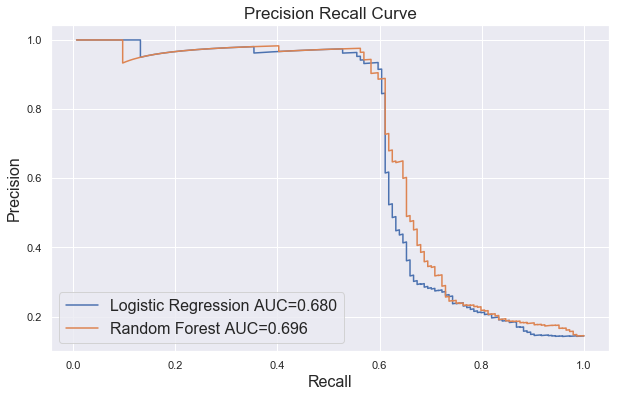

In [6]:
precision_lr, recall_lr, auc_lr = get_pr(pos_prob_lr, y_test)
precision_rf, recall_rf, auc_rf = get_pr(pos_prob_rf, y_test)

# draw PR-curve
plt.figure(figsize=(10, 6))
plt.plot(recall_lr, precision_lr, label="Logistic Regression AUC=%.3f" % (auc_lr))
plt.plot(recall_rf, precision_rf, label="Random Forest AUC=%.3f" % (auc_rf))
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("Precision Recall Curve", fontsize=17)
plt.legend(fontsize=16)

**Sklearn P-R curve**

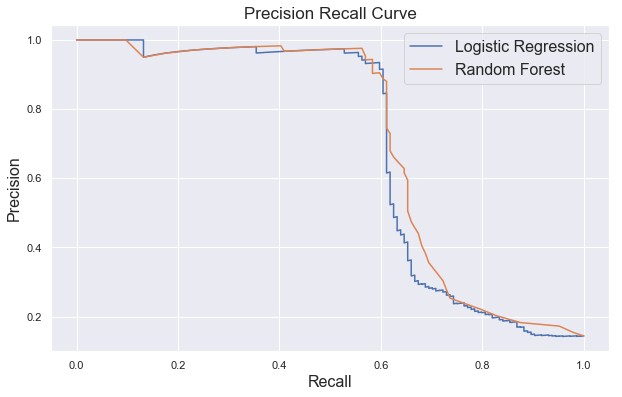

In [7]:
precision_lr, recall_lr, pos_seq_lr = precision_recall_curve(y_test, pos_prob_lr)
precision_rf, recall_rf, pos_seq_rf = precision_recall_curve(y_test, pos_prob_rf)

# draw PR-curve
plt.figure(figsize=(10, 6))
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("Precision Recall Curve", fontsize=17)
plt.legend(fontsize=16)

**Conclusion**:
* AUC(PR) = 0.68/0.69, PR curve focus on estimate of positive samples (Not so optimistic like ROC)

## 4. ROC (Receiver Operating Characteristic) and AUC (Area Under the Curve)

Make 10-Dimension Data to 2-Dimension via PCA and plot the distribution.
$$TPR = \frac{TP}{P}$$
$$FPR = \frac{FP}{P}$$
<img src="images/AUC.jpg" alt="drawing" style="width:350px;"/>

In [8]:
def get_roc(pos_prob, y_true):
    """
    Calculate ROC curve(fpr vs tpr), together with AUC.
    Agruments:
        pos_prob - probability of positive sample sorted in acending order
        y_true - true label of y
    Return:
        tpr - sequence of tp rate from positive sample with max probablity by f
        fpr - sequence of fp rate from positive sample with max probablity by f
        auc - area size under ROC
    """
    pos = y_true[y_true==1]; neg = y_true[y_true==0]
    # sort probablity in descending order and index
    threshold = np.sort(pos_prob)[::-1]; y = y_true[np.argsort(pos_prob)[::-1]]
    x_step = 1. / len(neg); y_step = 1. / len(pos)
    tprs = [0]; fprs = [0]; auc = 0
    tpr = 0; fpr = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tpr += y_step
        else:
            fpr += x_step
            auc += tpr * x_step
        tprs.append(tpr); fprs.append(fpr)
    return tprs, fprs, auc

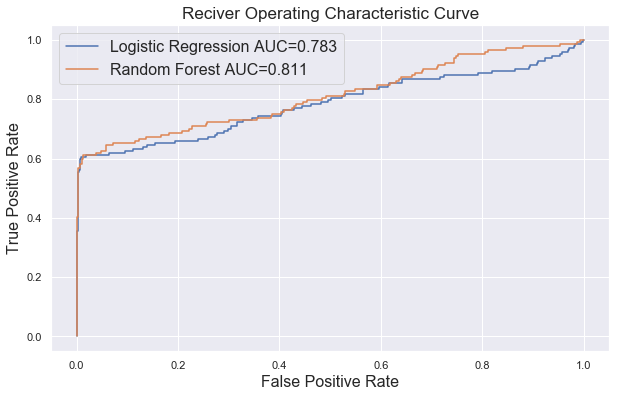

In [11]:
tprs_lr, fprs_lr, auc_lr = get_roc(pos_prob_lr, y_test)
tprs_rf, fprs_rf, auc_rf = get_roc(pos_prob_rf, y_test)

# draw ROC-curve
plt.figure(figsize=(10, 6))
plt.plot(fprs_lr, tprs_lr, label="Logistic Regression AUC=%.3f" % (auc_lr))
plt.plot(fprs_rf, tprs_rf, label="Random Forest AUC=%.3f" % (auc_rf))
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("Reciver Operating Characteristic Curve", fontsize=17)
plt.legend(fontsize=16)

**Sklearn ROC curve**

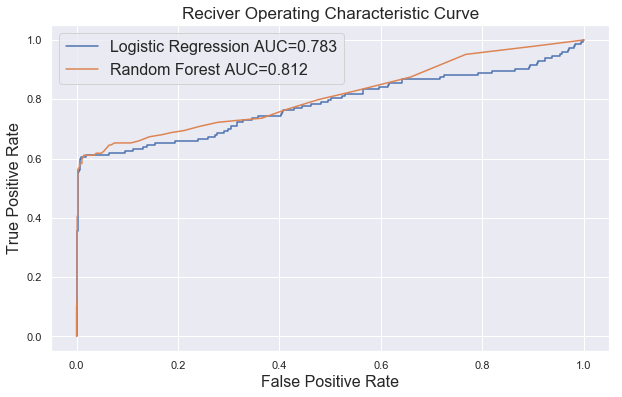

In [21]:
fprs_lr, tprs_lr, pos_seq_lr = roc_curve(y_test, pos_prob_lr)
fprs_rf, tprs_rf, pos_seq_rf = roc_curve(y_test, pos_prob_rf)

# draw ROC-curve
plt.figure(figsize=(10, 6))
plt.plot(fprs_lr, tprs_lr, label="Logistic Regression AUC=%.3f" % (roc_auc_score(y_test, pos_prob_lr)))
plt.plot(fprs_rf, tprs_rf, label="Random Forest AUC=%.3f" % (roc_auc_score(y_test, pos_prob_rf)))
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("Reciver Operating Characteristic Curve", fontsize=17)
plt.legend(fontsize=16)

**Conclusion**:
* AUC(ROC) = 0.812, optimistic
* Advantage of ROC
    1. Take balance positive and negative sample, TPR ~ Positive, FPR ~ Negative
    2. ROC's 2 factors: TPR and FPR don't directly depends on X, Y's distribution => If X, Y increase dynamically, ROC will probably keep relatively stable
<img src="images/ROC_ad.jpg" alt="drawing" style="width:650px;"/>
    3. imbalance case for ROC and PR
<img src="images/ROC_imbalance.jpg" alt="drawing" style="width:650px;"/>

### 4.1 ROC Stablity for X/Y argumentation(imbalance case)

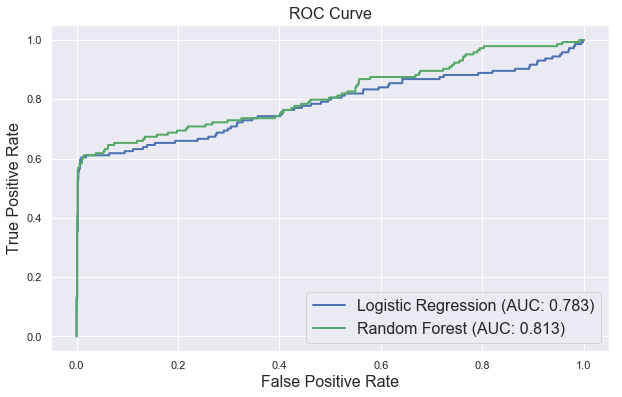

In [23]:
X_test_dup = np.vstack((X_test,X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0]))
# 10x倍负例的测试集
y_test_dup = np.array(y_test.tolist() + y_test[y_test==0].tolist()*9)   

pos_prob_lr_dup = lr.predict_proba(X_test_dup)[:,1]
pos_prob_rf_dup = rf.predict_proba(X_test_dup)[:,1]
tpr_lr_dup,fpr_lr_dup,auc_lr_dup = get_roc(pos_prob_lr_dup,y_test_dup)
tpr_rf_dup,fpr_rf_dup,auc_rf_dup = get_roc(pos_prob_rf_dup,y_test_dup)

plt.figure(figsize=(10,6))
plt.plot(fpr_lr_dup,tpr_lr_dup,label="Logistic Regression (AUC: {:.3f})".format(auc_lr_dup),linewidth=2)
plt.plot(fpr_rf_dup,tpr_rf_dup,'g',label="Random Forest (AUC: {:.3f})".format(auc_rf_dup),linewidth=2)
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=16)

In [24]:
pos_prob_lr_dup[:20]

array([0.15749218, 0.12059737, 0.02768971, 0.00976804, 0.06216012,
       0.04965623, 0.09921625, 0.05624147, 0.15616313, 0.05826308,
       0.08672132, 0.00790327, 0.16129754, 0.04049517, 0.14013108,
       0.07761468, 0.02121646, 0.03963158, 0.03787453, 0.04856339])

In [25]:
pos_prob_rf_dup[:20]

array([0.03, 0.  , 0.07, 0.03, 0.  , 0.05, 0.03, 0.03, 0.03, 0.18, 0.03,
       0.01, 0.02, 0.13, 0.02, 0.  , 0.19, 0.02, 0.02, 0.  ])

可以看到Logistic Regression的预测概率几乎没有重复，而Random Forest的预测概率则有很多重复，因为Logistic Regression可以天然输出概率，而Random Forest本质上属于树模型，只能输出离散值。scikit-learn中树模型的predict_proba() 方法表示的是一个叶节点上某一类别的样本比例，但只显示小数点后一位，致使大量样本的预测概率都一样。**当画ROC曲线时需要先将样本根据预测概率排序，若几个样本的概率一样，则只能按原来的顺序排列。上面的操作就是将所有累加的负例都排在了原始数据后面，致使正例的顺序都很靠前，造成Random Forest的结果好了不少。**解决办法就是将所有样本随机排序，就能产生和原来差不多的ROC曲线了

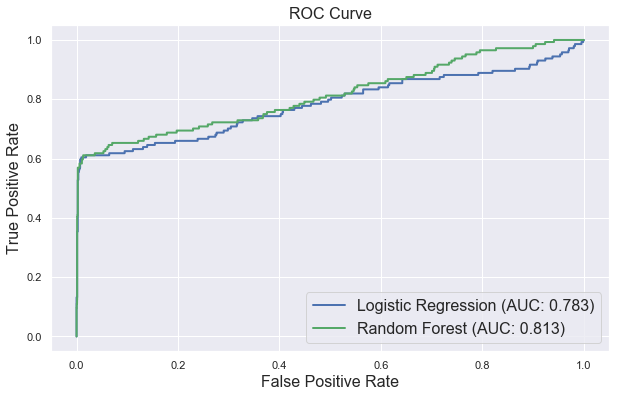

In [26]:
X_test_dup = np.vstack((X_test,X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0],X_test[y_test==0]))
# 10x倍负例的测试集
y_test_dup = np.array(y_test.tolist() + y_test[y_test==0].tolist()*9)  

index = np.random.permutation(len(X_test_dup))
X_test_dup = X_test_dup[index]
y_test_dup = y_test_dup[index]

pos_prob_lr_dup = lr.predict_proba(X_test_dup)[:,1]
pos_prob_rf_dup = rf.predict_proba(X_test_dup)[:,1]
tpr_lr_dup,fpr_lr_dup,auc_lr_dup = get_roc(pos_prob_lr_dup,y_test_dup)
tpr_rf_dup,fpr_rf_dup,auc_rf_dup = get_roc(pos_prob_rf_dup,y_test_dup)

plt.figure(figsize=(10,6))
plt.plot(fpr_lr_dup,tpr_lr_dup,label="Logistic Regression (AUC: {:.3f})".format(auc_lr_dup),linewidth=2)
plt.plot(fpr_rf_dup,tpr_rf_dup,'g',label="Random Forest (AUC: {:.3f})".format(auc_rf_dup),linewidth=2)
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=16)

**ROC曲线的缺点**
1. 上文提到ROC曲线的优点是不会随着类别分布的改变而改变，但这在某种程度上也是其缺点。因为负例N增加了很多，而曲线却没变，这等于产生了大量FP。像信息检索中如果主要关心正例的预测准确性的话，这就不可接受了。
2. 在类别不平衡的背景下，负例的数目众多致使FPR的增长不明显，导致ROC曲线呈现一个过分乐观的效果估计。ROC曲线的横轴采用FPR，根据$FPR = \frac{FP}{N} = \frac{FP}{FP+TN}$ ，当负例N的数量远超正例P时，FP的大幅增长只能换来FPR的微小改变。结果是虽然大量负例被错判成正例，在ROC曲线上却无法直观地看出来。（当然也可以只分析ROC曲线左边一小段）

举个例子，假设一个数据集有正例20，负例10000，开始时有20个负例被错判， $FPR = \frac{20}{20+9980} = 0.002$ ，接着又有20个负例错判， $FPR_{2} = \frac{40}{40+9960} =0.004 $，在ROC曲线上这个变化是很细微的。而与此同时Precision则从原来的0.5下降到了0.33，在PR曲线上将会是一个大幅下降。

## 5. Cost Curve

## 6. Hypothesis Test